In [1]:
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
# Cell 1: Imports
import json
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AdamW
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from bert_score import score
import re
import string
from tqdm import tqdm
import matplotlib.pyplot as plt

print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:
def load_tamil_data(file_path):
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        return data
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

In [4]:
class TamilQADataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.examples = []
        processed_count = 0

        for entry in tqdm(data["data"]):
            for paragraph in entry["paragraphs"]:
                context = paragraph["context"]
                for qa in paragraph["qas"]:
                    if not qa["is_impossible"]:
                        for answer in qa["answers"]:
                            example = self.process_qa_pair(
                                qa["question"],
                                context,
                                answer,
                                tokenizer,
                                max_length
                            )
                            if example:
                                self.examples.append(example)
                                processed_count += 1

        print(f"Successfully processed {processed_count} QA pairs")

    def process_qa_pair(self, question, context, answer, tokenizer, max_length):
        tokenized = tokenizer(
            question,
            context,
            truncation=True,
            max_length=max_length,
            padding="max_length",
            return_offsets_mapping=True,
            return_tensors="pt"
        )

        offset_mapping = tokenized["offset_mapping"].squeeze(0)
        answer_start = answer["answer_start"]
        answer_text = answer["text"]

        start_pos = end_pos = None
        for idx, (start, end) in enumerate(offset_mapping):
            if start <= answer_start < end:
                start_pos = idx
            if start < answer_start + len(answer_text) <= end:
                end_pos = idx
                break

        if start_pos is None or end_pos is None:
            return None

        return {
            "input_ids": tokenized["input_ids"].squeeze(0),
            "attention_mask": tokenized["attention_mask"].squeeze(0),
            "start_positions": torch.tensor(start_pos, dtype=torch.long),
            "end_positions": torch.tensor(end_pos, dtype=torch.long)
        }

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]


In [6]:
# Execute data loading and preprocessing
print("Starting data preprocessing...")
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
data = load_tamil_data("/content/sample_data/answers (1).json")
dataset = TamilQADataset(data, tokenizer)

Starting data preprocessing...


100%|██████████| 100/100 [00:08<00:00, 11.65it/s]

Successfully processed 126 QA pairs


In [7]:
# Create train/val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [8]:
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4)

In [9]:
print("Data preprocessing completed!")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Data preprocessing completed!
Training samples: 100
Validation samples: 26


In [10]:
# Cell 3: Model Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [11]:
# Initialize model
model = AutoModelForQuestionAnswering.from_pretrained("ai4bharat/indic-bert")
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of AlbertForQuestionAnswering were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
# Training loop
epochs = 20
training_losses = []
validation_losses = []

In [13]:
print("Starting training...")
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Training phase
    model.train()
    total_loss = 0
    train_progress = tqdm(train_dataloader, desc="Training")

    for batch in train_progress:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_progress.set_postfix({'loss': f"{loss.item():.4f}"})

    avg_train_loss = total_loss / len(train_dataloader)
    training_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    val_progress = tqdm(val_dataloader, desc="Validation")

    with torch.no_grad():
        for batch in val_progress:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss += outputs.loss.item()
            val_progress.set_postfix({'loss': f"{outputs.loss.item():.4f}"})

    avg_val_loss = val_loss / len(val_dataloader)
    validation_losses.append(avg_val_loss)

    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")

print("Training completed!")

Starting training...

Epoch 1/20


Validation: 100%|██████████| 7/7 [00:49<00:00,  7.03s/it, loss=5.1745]


Training Loss: 5.8676
Validation Loss: 5.5752

Epoch 2/20


Validation: 100%|██████████| 7/7 [00:50<00:00,  7.14s/it, loss=4.8652]


Training Loss: 5.2664
Validation Loss: 5.1821

Epoch 3/20


Validation: 100%|██████████| 7/7 [00:49<00:00,  7.11s/it, loss=4.5886]


Training Loss: 4.8561
Validation Loss: 5.0108

Epoch 4/20


Validation: 100%|██████████| 7/7 [00:50<00:00,  7.28s/it, loss=4.4605]


Training Loss: 4.5425
Validation Loss: 4.8934

Epoch 5/20


Validation: 100%|██████████| 7/7 [00:49<00:00,  7.05s/it, loss=4.7559]


Training Loss: 4.1866
Validation Loss: 5.0628

Epoch 6/20


Validation: 100%|██████████| 7/7 [00:51<00:00,  7.30s/it, loss=5.1394]


Training Loss: 3.8694
Validation Loss: 4.9651

Epoch 7/20


Validation: 100%|██████████| 7/7 [00:50<00:00,  7.21s/it, loss=5.0012]


Training Loss: 3.5581
Validation Loss: 5.0102

Epoch 8/20


Validation: 100%|██████████| 7/7 [00:49<00:00,  7.08s/it, loss=4.3349]


Training Loss: 3.0580
Validation Loss: 5.2621

Epoch 9/20


Validation: 100%|██████████| 7/7 [00:50<00:00,  7.15s/it, loss=4.4664]


Training Loss: 2.6900
Validation Loss: 5.5469

Epoch 10/20


Validation: 100%|██████████| 7/7 [00:51<00:00,  7.35s/it, loss=5.3958]


Training Loss: 2.3871
Validation Loss: 5.9313

Epoch 11/20


Validation: 100%|██████████| 7/7 [00:50<00:00,  7.18s/it, loss=5.7077]


Training Loss: 1.9889
Validation Loss: 5.8798

Epoch 12/20


Validation: 100%|██████████| 7/7 [00:48<00:00,  7.00s/it, loss=5.3684]


Training Loss: 1.8407
Validation Loss: 5.6588

Epoch 13/20


Validation: 100%|██████████| 7/7 [00:49<00:00,  7.03s/it, loss=5.5222]


Training Loss: 1.4410
Validation Loss: 5.8264

Epoch 14/20


Validation: 100%|██████████| 7/7 [00:50<00:00,  7.19s/it, loss=5.1896]


Training Loss: 1.2345
Validation Loss: 6.1266

Epoch 15/20


Validation: 100%|██████████| 7/7 [00:50<00:00,  7.28s/it, loss=5.6189]


Training Loss: 0.9908
Validation Loss: 6.2340

Epoch 16/20


Validation: 100%|██████████| 7/7 [00:51<00:00,  7.29s/it, loss=5.9869]


Training Loss: 0.9381
Validation Loss: 6.2393

Epoch 17/20


Validation: 100%|██████████| 7/7 [00:51<00:00,  7.37s/it, loss=6.1426]


Training Loss: 0.7173
Validation Loss: 6.3617

Epoch 18/20


Validation: 100%|██████████| 7/7 [00:53<00:00,  7.63s/it, loss=6.8462]


Training Loss: 0.7655
Validation Loss: 6.3753

Epoch 19/20


Validation: 100%|██████████| 7/7 [00:49<00:00,  7.12s/it, loss=5.9255]


Training Loss: 0.8413
Validation Loss: 6.3070

Epoch 20/20


Validation: 100%|██████████| 7/7 [00:50<00:00,  7.27s/it, loss=6.8565]

Training Loss: 0.6937
Validation Loss: 6.6901
Training completed!


In [14]:
# Cell 4: Save Model
print("Saving model...")
model.save_pretrained("./latest_IndicBERT_model")
tokenizer.save_pretrained("./latest_IndicBERT_model")
print("Model saved successfully!")

Saving model...
Model saved successfully!


In [15]:
# Cell 5: Evaluation
def normalize_answer(s):
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punctuation(text):
        return text.translate(str.maketrans('', '', string.punctuation))
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punctuation(lower(s))))

In [16]:
def compute_f1(pred_text, true_text):
    pred_tokens = normalize_answer(pred_text).split()
    true_tokens = normalize_answer(true_text).split()

    if len(pred_tokens) == 0 or len(true_tokens) == 0:
        return int(pred_tokens == true_tokens)

    common_tokens = set(pred_tokens) & set(true_tokens)
    if not common_tokens:
        return 0

    precision = len(common_tokens) / len(pred_tokens)
    recall = len(common_tokens) / len(true_tokens)
    f1 = 2 * precision * recall / (precision + recall)
    return f1

print("Starting evaluation...")
model.eval()
results = {
    'exact_match': [],
    'f1': [],
    'bleu': []
}

Starting evaluation...


In [17]:
with torch.no_grad():
    for batch in tqdm(val_dataloader, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        # Get predictions
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

        for i in range(len(batch['input_ids'])):
            pred_start = torch.argmax(start_logits[i]).item()
            pred_end = torch.argmax(end_logits[i]).item()

            pred_tokens = tokenizer.decode(batch['input_ids'][i][pred_start:pred_end + 1])
            true_tokens = tokenizer.decode(
                batch['input_ids'][i][
                    batch['start_positions'][i]:batch['end_positions'][i] + 1
                ]
            )

            results['exact_match'].append(
                int(normalize_answer(pred_tokens) == normalize_answer(true_tokens))
            )
            results['f1'].append(compute_f1(pred_tokens, true_tokens))
            results['bleu'].append(
                sentence_bleu([true_tokens.split()], pred_tokens.split())
            )

print("\nEvaluation Results:")
for metric, values in results.items():
    print(f"{metric}: {np.mean(values)*100:.2f}%")

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram o


Evaluation Results:
exact_match: 0.00%
f1: 1.84%
bleu: 0.00%


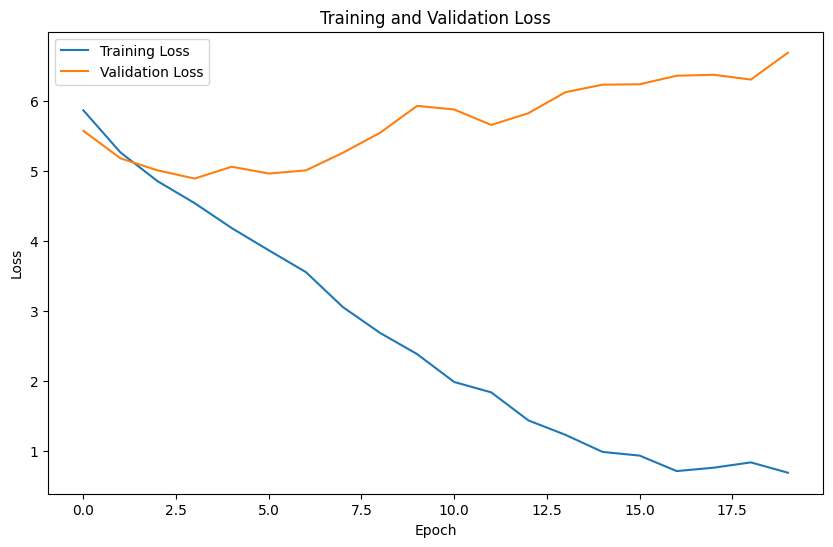

Training history plot saved as 'training_history.png'


In [18]:
# Cell 6: Plot Training History
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_history.png')
plt.show()
print("Training history plot saved as 'training_history.png'")

In [19]:
import shutil
from google.colab import files

# Define the folder path (Change this to your folder path)
folder_path = "/content/sample_data/model/latest_IndicBERT_model"

# Define the zip file name
zip_file = "/content/sample_data/model/latest_IndicBERT_model.zip"

# Zip the folder
shutil.make_archive(zip_file.replace(".zip", ""), 'zip', folder_path)

# Download the zipped folder
files.download(zip_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>